In [1]:
import warnings
warnings.filterwarnings('ignore')

# modules we'll use
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import explained_variance_score
from wrangle import summarize
from sklearn.model_selection import train_test_split
import scipy.stats as stats

from sklearn.feature_selection import SelectKBest, RFE, f_regression

import os
import missingno as msno

#Access Stored Data
from env import host,db,protocol,password,user,mysqlcon
import wrangle
import env
import wrangle_mall

## Acquire and Summarize

1. Acquire data from the cloud database.You will want to end with a single dataframe. Include the logerror field and all other fields related to the properties that are available. You will end up using all the tables in the database.Be sure to do the correct join (inner, outer, etc.). We do not want to eliminate properties purely because they may have a null value for airconditioningtypeid. - Only include properties with a transaction in 2017, and include only the last transaction for each property (so no duplicate property ID's), along with zestimate error and date of transaction. (Hint: read the docs for the .duplicated method) - Only include properties that have a latitude and longitude value.

2. Summarize your data (summary stats, info, dtypes, shape, distributions, value_counts, etc.)

3. Write a function that takes in a dataframe of observations and attributes and returns a dataframe where each row is an atttribute name, the first column is the number of rows with missing values for that attribute, and the second column is percent of total rows that have missing values for that attribute. Run the function and document takeaways from this on how you want to handle missing values.

In [2]:
df = wrangle.get_zillow()


In [3]:
df.head(3)

,Unnamed: 0,storytypeid,propertylandusetypeid,typeconstructiontypeid,id,airconditioningtypeid,architecturalstyletypeid,buildingclasstypeid,heatingorsystemtypeid,parcelid,...,heatingorsystemdesc,buildingclassdesc,architecturalstyledesc,airconditioningdesc,parcelid.1,logerror,trans_date,typeconstructiondesc,prop_landuse_desc,storydesc
0,0,NaN,266.0,NaN,77612,1.0,NaN,NaN,2.0,11213162,...,Central,NaN,NaN,Central,12826780,0.007204,2017-09-25,NaN,Condominium,NaN
1,1,NaN,261.0,NaN,77611,1.0,NaN,NaN,2.0,11212962,...,Central,NaN,NaN,Central,12773139,0.037129,2017-09-21,NaN,Single Family Residential,NaN
2,2,NaN,261.0,NaN,77610,1.0,NaN,NaN,2.0,11212639,...,Central,NaN,NaN,Central,17239384,0.013209,2017-09-21,NaN,Single Family Residential,NaN


In [4]:
df.shape

(77605, 70)

In [5]:
nulls_by_col = wrangle.nulls_by_col(df)
nulls_by_col

,num_rows_missing,percent_rows_missing
storydesc,77560,99.942014
basementsqft,77560,99.942014
storytypeid,77560,99.942014
yardbuildingsqft26,77539,99.914954
fireplaceflag,77480,99.838928
...,...,...
bathrooms,0,0.000000
rawcensustractandblock,0,0.000000
regionidcounty,0,0.000000
assessmentyear,0,0.000000


In [6]:
nulls_by_row = wrangle.nulls_by_row(df)
nulls_by_row

,num_cols_missing,percent_cols_missing
32549,50,71.428571
32593,50,71.428571
17740,50,71.428571
2813,49,70.000000
47047,49,70.000000
...,...,...
36304,24,34.285714
36209,24,34.285714
34884,24,34.285714
64401,24,34.285714


In [7]:
#call out the specific row that has with 71.42% null values
print("")
display(df.iloc[32549])

Unnamed: 0                                  32549
storytypeid                                   NaN
propertylandusetypeid                       270.0
typeconstructiontypeid                        NaN
id                                          44791
                                   ...           
logerror                                -0.003344
trans_date                             2017-06-09
typeconstructiondesc                          NaN
prop_landuse_desc         Residential Common Area
storydesc                                     NaN
Name: 32549, Length: 70, dtype: object

In [8]:
summary = wrangle.summarize(df)

SUMMARY REPORT


Dataframe head: 
   Unnamed: 0  storytypeid  propertylandusetypeid  typeconstructiontypeid  \
0           0          NaN                  266.0                     NaN   
1           1          NaN                  261.0                     NaN   
2           2          NaN                  261.0                     NaN   

      id  airconditioningtypeid  architecturalstyletypeid  \
0  77612                    1.0                       NaN   
1  77611                    1.0                       NaN   
2  77610                    1.0                       NaN   

   buildingclasstypeid  heatingorsystemtypeid  parcelid  ...  \
0                  NaN                    2.0  11213162  ...   
1                  NaN                    2.0  11212962  ...   
2                  NaN                    2.0  11212639  ...   

   heatingorsystemdesc  buildingclassdesc  architecturalstyledesc  \
0              Central                NaN                     NaN   
1              Ce

(0.988, 2.1]       38
(2.1, 3.2]        474
(3.2, 4.3]      11423
(4.3, 5.4]       2669
(5.4, 6.5]      14636
(6.5, 7.6]       4938
(7.6, 8.7]      13205
(8.7, 9.8]       1801
(9.8, 10.9]       292
(10.9, 12.0]      843
Name: buildingqualitytypeid, dtype: int64 

(0.98, 2.9]     50916
(2.9, 4.8]      21470
(4.8, 6.7]       1658
(6.7, 8.6]        277
(8.6, 10.5]        54
(10.5, 12.4]       11
(12.4, 14.3]        2
(14.3, 16.2]        0
(16.2, 18.1]        0
(18.1, 20.0]        2
Name: calculatedbathnbr, dtype: int64 

(65.93299999999999, 65.947]      0
(65.947, 65.96]                  0
(65.96, 65.974]                  0
(65.974, 65.987]                 0
(65.987, 66.0]                 513
(66.0, 66.013]                   0
(66.013, 66.026]                 0
(66.026, 66.04]                  0
(66.04, 66.053]                  0
(66.053, 66.066]                 0
Name: decktypeid, dtype: int64 

(31.048, 1642.1]      4598
(1642.1, 3237.2]      1287
(3237.2, 4832.3]        74
(4832.3, 642

                        num_rows_missing  percent_rows_missing
storydesc                          77560             99.942014
basementsqft                       77560             99.942014
storytypeid                        77560             99.942014
yardbuildingsqft26                 77539             99.914954
fireplaceflag                      77480             99.838928
...                                  ...                   ...
bathrooms                              0              0.000000
rawcensustractandblock                 0              0.000000
regionidcounty                         0              0.000000
assessmentyear                         0              0.000000
Unnamed: 0                             0              0.000000

[70 rows x 2 columns]
nulls in dataframe by row: 
       num_cols_missing  percent_cols_missing
32549                50             71.428571
32593                50             71.428571
17740                50             71.428571
2813     

In [9]:
df.columns

Index(['Unnamed: 0', 'storytypeid', 'propertylandusetypeid',
       'typeconstructiontypeid', 'id', 'airconditioningtypeid',
       'architecturalstyletypeid', 'buildingclasstypeid',
       'heatingorsystemtypeid', 'parcelid', 'basementsqft', 'bathrooms',
       'bedrooms', 'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'area', 'finishedsquarefeet12',
       'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50',
       'finishedsquarefeet6', 'fips', 'fireplacecnt', 'fullbathcnt',
       'garagecarcnt', 'garagetotalsqft', 'hashottuborspa', 'latitude',
       'longitude', 'lotsizesquarefeet', 'poolcnt', 'poolsizesum',
       'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'county_landuse_code',
       'zoning_desc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'threequarterbathnbr', 'unitcnt', 'yardbuildingsqft17',
       'yardbuildingsqft26', 'yea

## Prepare

1. Remove any properties that are likely to be something other than single unit properties. (e.g. no duplexes, no land/lot, ...). There are multiple ways to estimate that a property is a single unit, and there is not a single "right" answer.

2. Create a function that will drop rows or columns based on the percent of values that are missing: handle_missing_values(df, prop_required_column, prop_required_row).
* The input:
  * A dataframe
  
  * A number between 0 and 1 that represents the proportion, for each column, of rows with non-missing values required to keep the column. i.e. if prop_required_column = .6, then you are requiring a column to have at least 60% of values not-NA (no more than 40% missing).
  
  * A number between 0 and 1 that represents the proportion, for each row, of columns/variables with non-missing values required to keep the row. For example, if prop_required_row = .75, then you are requiring a row to have at least 75% of variables with a non-missing value (no more that 25% missing).
* The output:
  * The dataframe with the columns and rows dropped as indicated. Be sure to drop the columns prior to the rows in your function.

* hint:
  * Look up the dropna documentation.
  
  * You will want to compute a threshold from your input values (prop_required) and total number of rows or columns.
  
3. Encapsulate your work inside of functions in a wrangle_zillow.py module.

In [10]:
#dropped rows not equal to 'Single Family Residential'
df = df[df.prop_landuse_desc == 'Single Family Residential']

In [11]:
df

,Unnamed: 0,storytypeid,propertylandusetypeid,typeconstructiontypeid,id,airconditioningtypeid,architecturalstyletypeid,buildingclasstypeid,heatingorsystemtypeid,parcelid,...,heatingorsystemdesc,buildingclassdesc,architecturalstyledesc,airconditioningdesc,parcelid.1,logerror,trans_date,typeconstructiondesc,prop_landuse_desc,storydesc
1,1,NaN,261.0,NaN,77611,1.0,NaN,NaN,2.0,11212962,...,Central,NaN,NaN,Central,12773139,0.037129,2017-09-21,NaN,Single Family Residential,NaN
2,2,NaN,261.0,NaN,77610,1.0,NaN,NaN,2.0,11212639,...,Central,NaN,NaN,Central,17239384,0.013209,2017-09-21,NaN,Single Family Residential,NaN
3,3,NaN,261.0,NaN,77609,1.0,NaN,NaN,2.0,11212539,...,Central,NaN,NaN,Central,11000655,0.020615,2017-09-20,NaN,Single Family Residential,NaN
4,4,NaN,261.0,NaN,77608,1.0,NaN,NaN,2.0,11212264,...,Central,NaN,NaN,Central,10833991,-0.002245,2017-09-20,NaN,Single Family Residential,NaN
5,5,NaN,261.0,NaN,77587,1.0,NaN,NaN,2.0,11207072,...,Central,NaN,NaN,Central,10855745,0.002138,2017-09-19,NaN,Single Family Residential,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77563,77563,NaN,261.0,NaN,62,NaN,NaN,NaN,NaN,11954547,...,NaN,NaN,NaN,NaN,12691507,0.069858,2017-01-02,NaN,Single Family Residential,NaN
77572,77572,NaN,261.0,NaN,71,NaN,NaN,NaN,NaN,12077147,...,NaN,NaN,NaN,NaN,10808296,0.008475,2017-01-02,NaN,Single Family Residential,NaN
77577,77577,NaN,261.0,NaN,76,NaN,NaN,NaN,NaN,12167947,...,NaN,NaN,NaN,NaN,13069118,-0.006370,2017-01-02,NaN,Single Family Residential,NaN
77598,77598,NaN,261.0,NaN,97,NaN,NaN,NaN,NaN,12537947,...,NaN,NaN,NaN,NaN,14249444,0.020950,2017-01-02,NaN,Single Family Residential,NaN


In [12]:
df = wrangle.handle_missing_values(df, prop_required_columns=0.6, prop_required_rows=0.75)

In [13]:
df

,Unnamed: 0,propertylandusetypeid,id,heatingorsystemtypeid,parcelid,bathrooms,bedrooms,buildingqualitytypeid,calculatedbathnbr,area,...,tax_value,assessmentyear,landtaxvaluedollarcnt,tax_amount,censustractandblock,heatingorsystemdesc,parcelid.1,logerror,trans_date,prop_landuse_desc
1,1,261.0,77611,2.0,11212962,2.0,3.0,6.0,2.0,1549.0,...,198988.0,2016.0,49747.0,3331.81,6.037911e+13,Central,12773139,0.037129,2017-09-21,Single Family Residential
2,2,261.0,77610,2.0,11212639,3.0,4.0,8.0,3.0,1780.0,...,125923.0,2016.0,25179.0,2394.26,6.037911e+13,Central,17239384,0.013209,2017-09-21,Single Family Residential
3,3,261.0,77609,2.0,11212539,3.0,4.0,8.0,3.0,1921.0,...,162019.0,2016.0,32453.0,2860.33,6.037911e+13,Central,11000655,0.020615,2017-09-20,Single Family Residential
4,4,261.0,77608,2.0,11212264,2.0,3.0,8.0,2.0,1600.0,...,180715.0,2016.0,42764.0,3677.13,6.037911e+13,Central,10833991,-0.002245,2017-09-20,Single Family Residential
5,5,261.0,77587,2.0,11207072,3.0,4.0,8.0,3.0,2262.0,...,259000.0,2016.0,66200.0,4836.15,6.037911e+13,Central,10855745,0.002138,2017-09-19,Single Family Residential
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77532,77532,261.0,31,2.0,11544747,4.0,3.0,11.0,4.0,1620.0,...,847770.0,2016.0,508238.0,10244.94,NaN,Central,14338242,-0.019546,2017-01-02,Single Family Residential
77534,77534,261.0,33,2.0,11585547,2.0,3.0,8.0,2.0,2077.0,...,646760.0,2016.0,436568.0,7924.68,NaN,Central,12155445,-0.040807,2017-01-02,Single Family Residential
77563,77563,261.0,62,NaN,11954547,0.0,0.0,NaN,NaN,1200.0,...,5328.0,2016.0,4733.0,91.60,NaN,NaN,12691507,0.069858,2017-01-02,Single Family Residential
77598,77598,261.0,97,NaN,12537947,0.0,0.0,NaN,NaN,171.0,...,6920.0,2016.0,6920.0,255.17,NaN,NaN,14249444,0.020950,2017-01-02,Single Family Residential


In [14]:
df.isna().sum()

Unnamed: 0                    0
propertylandusetypeid         0
id                            0
heatingorsystemtypeid     18798
parcelid                      0
bathrooms                     0
bedrooms                      0
buildingqualitytypeid     18883
calculatedbathnbr           180
area                         27
finishedsquarefeet12        215
fips                          0
fullbathcnt                 180
latitude                      0
longitude                     0
lotsizesquarefeet           304
county_landuse_code           0
zoning_desc               18719
rawcensustractandblock        0
regionidcity               1007
regionidcounty                0
regionidzip                  63
roomcnt                       0
unitcnt                   18793
year_built                   47
structure_taxvalue           75
tax_value                     2
assessmentyear                0
landtaxvaluedollarcnt         2
tax_amount                   79
censustractandblock         280
heatingo

In [15]:
wrangle.summarize(df)

SUMMARY REPORT


Dataframe head: 
   Unnamed: 0  propertylandusetypeid     id  heatingorsystemtypeid  parcelid  \
1           1                  261.0  77611                    2.0  11212962   
2           2                  261.0  77610                    2.0  11212639   
3           3                  261.0  77609                    2.0  11212539   

   bathrooms  bedrooms  buildingqualitytypeid  calculatedbathnbr    area  ...  \
1        2.0       3.0                    6.0                2.0  1549.0  ...   
2        3.0       4.0                    8.0                3.0  1780.0  ...   
3        3.0       4.0                    8.0                3.0  1921.0  ...   

   tax_value  assessmentyear  landtaxvaluedollarcnt  tax_amount  \
1   198988.0          2016.0                49747.0     3331.81   
2   125923.0          2016.0                25179.0     2394.26   
3   162019.0          2016.0                32453.0     2860.33   

   censustractandblock  heatingorsystemdesc parceli

       num_cols_missing  percent_cols_missing
52629                 9                  25.0
53133                 9                  25.0
73183                 9                  25.0
2784                  9                  25.0
47959                 9                  25.0
...                 ...                   ...
31174                 0                   0.0
31175                 0                   0.0
31176                 0                   0.0
31177                 0                   0.0
38844                 0                   0.0

[55873 rows x 2 columns]


In [16]:
df.buildingqualitytypeid.value_counts()

6.0     11973
4.0      9436
8.0      8633
7.0      3181
5.0      1733
9.0      1015
11.0      487
10.0      238
3.0       188
12.0       86
1.0        14
2.0         6
Name: buildingqualitytypeid, dtype: int64

In [17]:
#Pulled in data dictionary 
dd = pd.read_excel('zillow_data_dictionary.xlsx')  


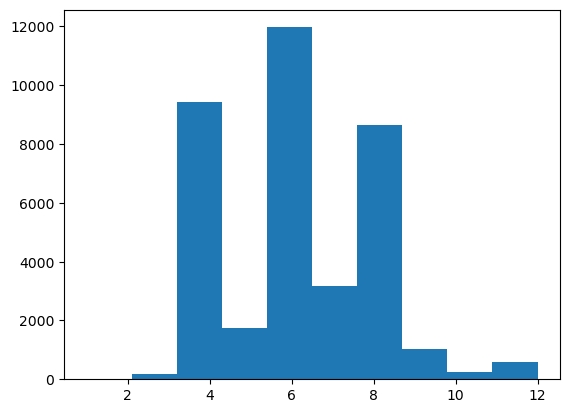

In [18]:
plt.hist(df.buildingqualitytypeid)
plt.show()

In [19]:
df.heatingorsystemtypeid.value_counts()

2.0     21753
7.0     14739
6.0       499
20.0       68
13.0       11
18.0        4
1.0         1
Name: heatingorsystemtypeid, dtype: int64

In [20]:
df.heatingorsystemdesc.value_counts()

Central       21753
Floor/Wall    14739
Forced air      499
Solar            68
None             11
Radiant           4
Baseboard         1
Name: heatingorsystemdesc, dtype: int64

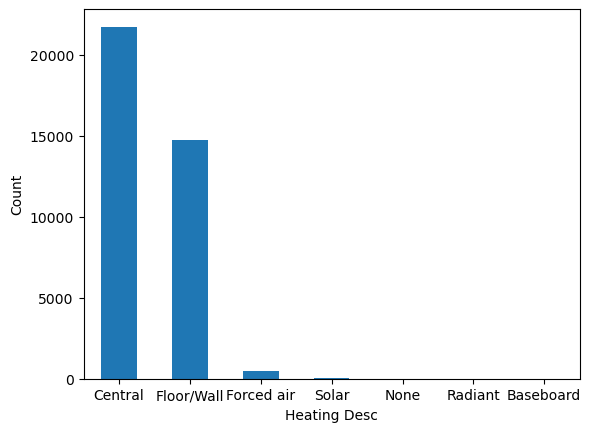

In [21]:
df['heatingorsystemdesc'].value_counts().plot(kind='bar', xlabel='Heating Desc', ylabel='Count', rot=0)
plt.show()

In [22]:
def remaining_missing(df):
    '''
    This function takes in a dataframe 
    and list all columns with missing values
    '''
    df = df.columns[df.isnull().any()]
    
    return df

In [23]:
remaining_missing(df)

Index(['heatingorsystemtypeid', 'buildingqualitytypeid', 'calculatedbathnbr',
       'area', 'finishedsquarefeet12', 'fullbathcnt', 'lotsizesquarefeet',
       'zoning_desc', 'regionidcity', 'regionidzip', 'unitcnt', 'year_built',
       'structure_taxvalue', 'tax_value', 'landtaxvaluedollarcnt',
       'tax_amount', 'censustractandblock', 'heatingorsystemdesc'],
      dtype='object')

In [24]:
wrangle.impute_remaining(df)

,Unnamed: 0,propertylandusetypeid,id,heatingorsystemtypeid,parcelid,bathrooms,bedrooms,buildingqualitytypeid,calculatedbathnbr,area,...,tax_value,assessmentyear,landtaxvaluedollarcnt,tax_amount,censustractandblock,heatingorsystemdesc,parcelid.1,logerror,trans_date,prop_landuse_desc
1,1,261.0,77611,2.0,11212962,2.0,3.0,6.0,2.0,1549.0,...,198988.0,2016.0,49747.0,3331.81,60379107111010.0,Central,12773139,0.037129,2017-09-21,Single Family Residential
2,2,261.0,77610,2.0,11212639,3.0,4.0,8.0,3.0,1780.0,...,125923.0,2016.0,25179.0,2394.26,60379107132003.0,Central,17239384,0.013209,2017-09-21,Single Family Residential
3,3,261.0,77609,2.0,11212539,3.0,4.0,8.0,3.0,1921.0,...,162019.0,2016.0,32453.0,2860.33,60379107051005.0,Central,11000655,0.020615,2017-09-20,Single Family Residential
4,4,261.0,77608,2.0,11212264,2.0,3.0,8.0,2.0,1600.0,...,180715.0,2016.0,42764.0,3677.13,60379107051018.0,Central,10833991,-0.002245,2017-09-20,Single Family Residential
5,5,261.0,77587,2.0,11207072,3.0,4.0,8.0,3.0,2262.0,...,259000.0,2016.0,66200.0,4836.15,60379106051005.0,Central,10855745,0.002138,2017-09-19,Single Family Residential
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77532,77532,261.0,31,2.0,11544747,4.0,3.0,11.0,4.0,1620.0,...,847770.0,2016.0,508238.0,10244.94,60371417002000.0,Central,14338242,-0.019546,2017-01-02,Single Family Residential
77534,77534,261.0,33,2.0,11585547,2.0,3.0,8.0,2.0,2077.0,...,646760.0,2016.0,436568.0,7924.68,60371417002000.0,Central,12155445,-0.040807,2017-01-02,Single Family Residential
77563,77563,261.0,62,2.0,11954547,0.0,0.0,6.0,2.0,1200.0,...,5328.0,2016.0,4733.0,91.6,60371417002000.0,Central,12691507,0.069858,2017-01-02,Single Family Residential
77598,77598,261.0,97,2.0,12537947,0.0,0.0,6.0,2.0,171.0,...,6920.0,2016.0,6920.0,255.17,60371417002000.0,Central,14249444,0.020950,2017-01-02,Single Family Residential


In [25]:
df.isna().sum()

Unnamed: 0                0
propertylandusetypeid     0
id                        0
heatingorsystemtypeid     0
parcelid                  0
bathrooms                 0
bedrooms                  0
buildingqualitytypeid     0
calculatedbathnbr         0
area                      0
finishedsquarefeet12      0
fips                      0
fullbathcnt               0
latitude                  0
longitude                 0
lotsizesquarefeet         0
county_landuse_code       0
zoning_desc               0
rawcensustractandblock    0
regionidcity              0
regionidcounty            0
regionidzip               0
roomcnt                   0
unitcnt                   0
year_built                0
structure_taxvalue        0
tax_value                 0
assessmentyear            0
landtaxvaluedollarcnt     0
tax_amount                0
censustractandblock       0
heatingorsystemdesc       0
parcelid.1                0
logerror                  0
trans_date                0
prop_landuse_desc   

## Mall Customers

* Notebook

1. Acquire data from the customers table in the mall_customers database.
2. Summarize the data (include distributions and descriptive statistics).
3. Detect outliers using IQR.
4. Split data into train, validate, and test.
5. Encode categorical columns using a one hot encoder (pd.get_dummies).
6. Handles missing values.
7. Scaling

* Encapsulate your work in a wrangle_mall.py python module.

## Acquire

In [26]:
df = wrangle_mall.get_mall_data()

In [27]:
df

,Unnamed: 0,customer_id,gender,age,annual_income,spending_score
0,0,1,Male,19,15,39
1,1,2,Male,21,15,81
2,2,3,Female,20,16,6
3,3,4,Female,23,16,77
4,4,5,Female,31,17,40
...,...,...,...,...,...,...
195,195,196,Female,35,120,79
196,196,197,Female,45,126,28
197,197,198,Male,32,126,74
198,198,199,Male,32,137,18


## Prepare

In [28]:
def train_validate_test_split(df, target, seed=123):
    '''
    This function takes in a dataframe and splits the data into train, validate and test. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, random_state=seed)
    
    train, validate = train_test_split(train_validate, test_size=0.3, random_state=seed)
    return train, validate, test


In [29]:
def scale_my_data(train, validate, test):
    '''
    scale my data using minmaxscaler and add it back to my input datasets
    '''
    scaler = MinMaxScaler()
    scaler.fit(train[['age', 'annual_income']])
    
    X_train_scaled = scaler.transform(train[['age', 'annual_income']])
    X_validate_scaled = scaler.transform(validate[['age', 'annual_income']])
    X_test_scaled = scaler.transform(test[['age', 'annual_income']])

    train[['age_scaled', 'annual_income_scaled']] = X_train_scaled
    validate[['age_scaled', 'annual_income_scaled']] = X_validate_scaled
    test[['age_scaled', 'annual_income_scaled']] = X_test_scaled
    return train, validate, test

In [30]:
def prep_mall(df):
    '''
    dummy var for gender into is_male
    split on target of 'spending_score'
    scale age and annual income. 
    '''
    df['is_male'] = pd.get_dummies(df['gender'], drop_first=True)['Male']
    train, validate, test = train_validate_test_split(df, target='spending_score', seed=1349)
    train, validate, test = scale_my_data(train, validate, test)
    
    print(f'df: {df.shape}')
    print()
    print(f'train: {train.shape}')
    print(f'validate: {validate.shape}')
    print(f'test: {test.shape}')
    return df, train, validate, test

In [31]:
df, train, validate, test = prep_mall(df)


df: (200, 7)

train: (112, 9)
validate: (48, 9)
test: (40, 9)


In [32]:
x_train_scaled, x_validate_scaled, x_test_scaled = scale_my_data(train, validate, test)

In [33]:
x_train_scaled.head()

,Unnamed: 0,customer_id,gender,age,annual_income,spending_score,is_male,age_scaled,annual_income_scaled
26,26,27,Female,45,28,32,0,0.519231,0.106557
23,23,24,Male,31,25,73,1,0.250000,0.081967
39,39,40,Female,20,37,75,0,0.038462,0.180328
37,37,38,Female,30,34,73,0,0.230769,0.155738
56,56,57,Female,51,44,50,0,0.634615,0.237705


## Explore!
Ask your question

Vizualize it

Perform a stats test, if needed

Write your takeaway

## Q1. What is the distribution of each variable?
Since I'm doing at univariate exploration, I can use the original dataset.

In [34]:
df.columns

Index(['Unnamed: 0', 'customer_id', 'gender', 'age', 'annual_income',
       'spending_score', 'is_male'],
      dtype='object')

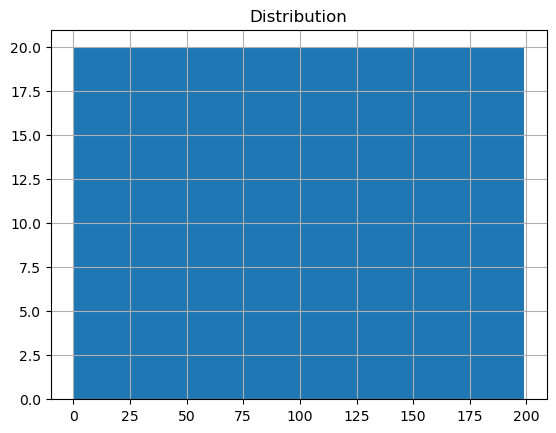

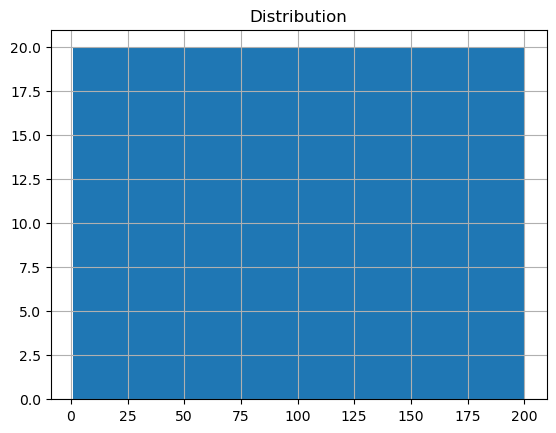

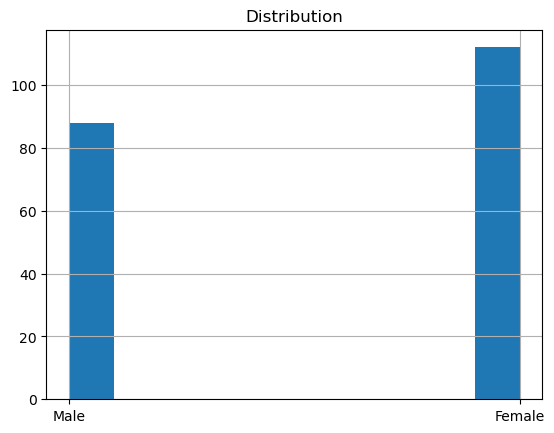

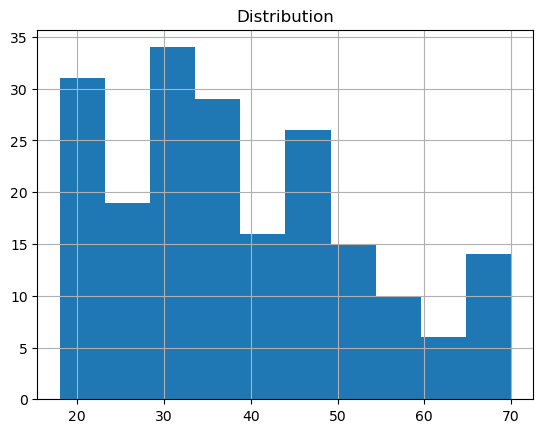

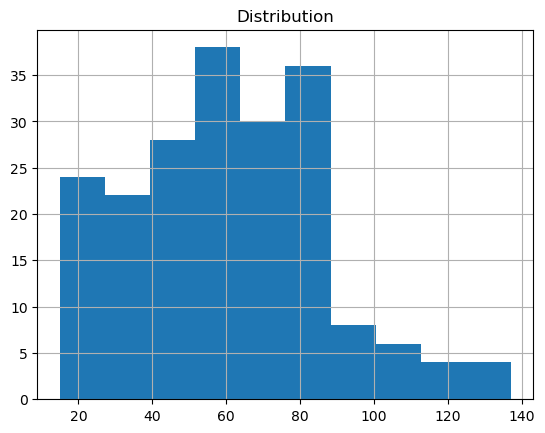

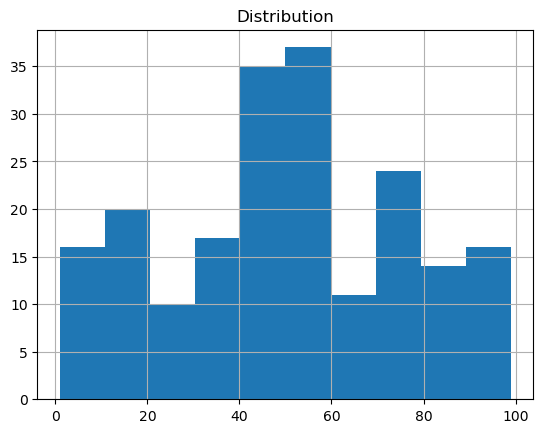

In [35]:
for col in df.columns[:-1]:
    df[col].hist()
    plt.title('Distribution')
    plt.show()

# Takeaways
slight inbalance in gender
age and annual_income is right skewed
spending_score is normally distribution
Note: I care about distributions for the stats test

## Q2. Does the spending score differ across gender?

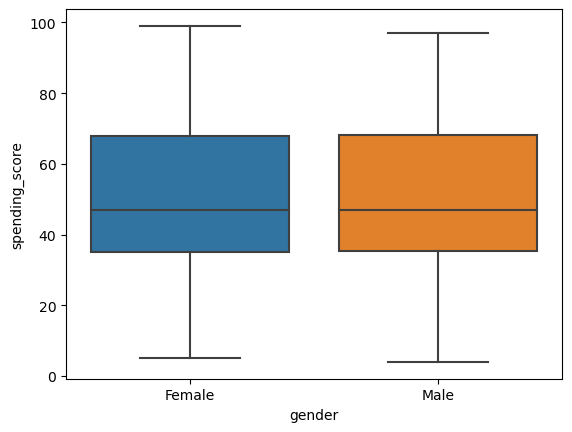

In [36]:
sns.boxplot(data=x_train_scaled, x='gender', y='spending_score')
plt.show()

<AxesSubplot:xlabel='gender', ylabel='spending_score'>

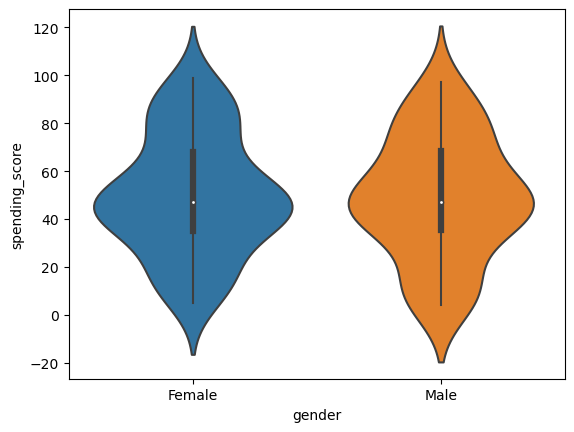

In [37]:
sns.violinplot(data=x_train_scaled, x='gender', y='spending_score')


In [38]:
stats.levene(x_train_scaled[x_train_scaled.gender=='Male'].spending_score,
            x_train_scaled[x_train_scaled.gender=='Female'].spending_score)

LeveneResult(statistic=0.016334996444000886, pvalue=0.8985339363273774)

In [39]:
stats.ttest_ind(x_train_scaled[x_train_scaled.gender=='Male'].spending_score,
            x_train_scaled[x_train_scaled.gender=='Female'].spending_score)

Ttest_indResult(statistic=-0.2520372896728062, pvalue=0.8014825487089098)

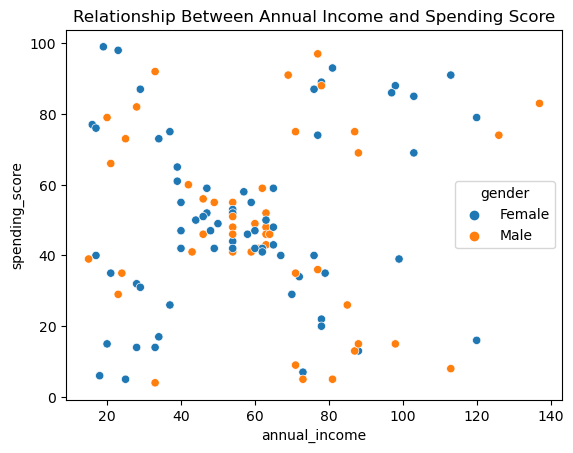

In [40]:
sns.scatterplot(data=x_train_scaled, x='annual_income', y='spending_score', hue='gender')
plt.title('Relationship Between Annual Income and Spending Score')
plt.show()

In [41]:
stats.spearmanr(x_train_scaled.annual_income, x_train_scaled.spending_score)

SpearmanrResult(correlation=0.0139166413882597, pvalue=0.8842097894086705)

<AxesSubplot:xlabel='age', ylabel='spending_score'>

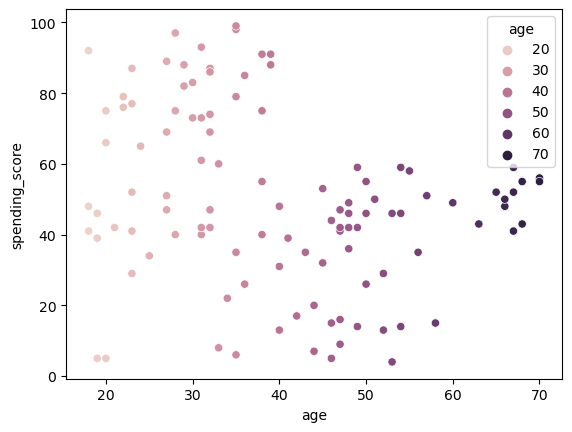

In [42]:
sns.scatterplot(data=x_train_scaled, x='age', y='spending_score', hue='age')

In [43]:
x_train_scaled['age_bins'] = pd.cut(x_train_scaled.age,[0,40,80], labels=['40_and_under', 'over_40'])

In [44]:
x_train_scaled['age_bins']

26          over_40
23     40_and_under
39     40_and_under
37     40_and_under
56          over_40
           ...     
176         over_40
194         over_40
12          over_40
34          over_40
117         over_40
Name: age_bins, Length: 112, dtype: category
Categories (2, object): ['40_and_under' < 'over_40']